# Simulating Branching Processes with Various Lifetime Distributions
Michael Murrietta

4/4/2018

## Introduction
One description of a branching process is one that begins with a single entity that can spawn child entities during its lifetime and those will cease to begin their "work" until the parent entity completes. During their "work" these child entities can also create child entities with the same conditions. This is called a "Birth-and-Assassination" process and was first described by David Aldous and William Krebs. The main parameters of interest in this scheme are the distributions that govern lifetimes of each entity and the distributions that govern how many child entities are spawned. Deborah Nolan and Duncan Temple Lang explain the usage of the Poisson distribution in describing how many entities are spawned during a fixed time interval and also how the exponential distribution describes their spawn times and life lengths. This exercise explores the use of any other continuous distribution in describing life lengths and spawn times.

## Abstract
Functions created by Nolan and Lang to model the Birth-and-Assassination type branching process were modified to allow for any random number generating function to be used to model lifetimes. An analysis similar to the authors' is explored using the uniform distribution with a range of $[80, 100]$. The original exploration included a grid search over the parameters kappa and lambda however kappa is not necessarily useful in the context of using other random number generator functions so an exploration of the lifetime range was explored instead. The results show that larger values of lambda tend to lower the lifetime range where high volume trials are generated.

#### Problem Statement:
Problem 11 from chapter 7 of the text by Nolan and Lang [Nolan & Lang, 2015]:

+ Consider other probability functions to describe the lifetime of a process. Revise `familyTree()` and `genKidsV()` to take as an argument the random number generator for any probability distribution. The functions `familyTree()` and `genKidsV()` are to use this probability distribution (with arguments that may be specific to the distributions) to generate the completion times of jobs.

## Methods
The problem was most easily addressed using the `...` operator in `R`. Each function was modified to incorporate a `FUN` and `...` parameter. The `FUN` parameter is a function and the `...` are the named parameters used in `FUN`. The convention in `R` is to use explicit names in `...` rather than abbreviations so it is up to the user to specify the correctly named arguments for `FUN`. Some parameter names had to be changed in `genKidsV`, namely `min` and `max` since the random number generating function `runif` uses these parameters as well. Most of the exploration and plots are due to an analogous exploration followed in chapter 8 by the authors [Nolan & Lang, 2015]. The `MCBA2` function is a copy of the authors' `MCBA` function but modified to include 2 more parameters for min and max specifically for use with `runif`.

In [1]:
#different prob dists to try
#runif(10)  #(may want to round to nearest integer)
#rnorm(n=10, mean=0, sd=1) #also may want to discretize
#rbinom(n=10, size=100, prob=0.5) #perhaps convert to a proportion of successes?
#rexp(n=100, rate=10) #mean is 1/rate
#rgamma(n=100, shape=20)

In [2]:
genKidsV2 = function(bTimes, cTimes, parentID, lambda = 0.5, FUN=rexp, ...) {
       # Determine how many children each job has
  parentAge = cTimes - bTimes
  numKids = rpois(n = length(parentAge), lambda = lambda * parentAge)
  
  if (sum(numKids) == 0) return(NULL)
  
       # Determine the birth times of the children  
      #added "n" to the end of the min and max used in the lambda function
      #to avoid ambiguity if using FUN=runif(n, min, max)
  kidStats = 
    mapply(function(n, minn, maxn) {
      births = sort(runif(n, minn, maxn))
      runtimes = FUN(n, ...)
      completes = rep(maxn, n) + runtimes
      data.frame(births, completes)
    },
           n = numKids , minn = bTimes, maxn = cTimes, 
           SIMPLIFY = FALSE)
  
 
  return(data.frame(parentID = rep(parentID, numKids),
                    kidID = 1:sum(numKids), 
                    births = unlist(lapply(kidStats, "[[", "births")), 
                    completes = unlist(lapply(kidStats,"[[", "completes"))
                    ))
}

In [3]:
familyTree2 = function(lambda = 0.5, 
                      maxGen = 10, maxOffspring = 1000,
                     FUN = rexp, ...) {
  #assume all dots belong to FUN, this means we need to explicitly specify
  #rate is kappa if using rexp

       # Return value - a list with 1 data frame per generation.
  allGens = vector(mode = "list", length = maxGen)
  
       # Generate root of the tree
  allGens[[1]] = data.frame(parentID = NA, kidID = 1, 
                            births = 0, 
                            completes = FUN(n=1, ...))
  
  currentNumOffspring = 0

       # Generate future generations, one at a time.
  for (i in 2:maxGen) {
    nextGen = genKidsV2(bTimes = allGens[[ (i - 1) ]]$births,
                       cTimes = allGens[[ (i - 1) ]]$completes,
                       parentID = allGens[[ (i - 1) ]]$kidID,
                       lambda = lambda, FUN=FUN, ...)
    if (is.null(nextGen)) return(allGens[ 1:(i - 1) ]) 
    allGens[[ i ]] = nextGen
    currentNumOffspring = currentNumOffspring + nrow(nextGen)
    if (currentNumOffspring > maxOffspring) 
      return(allGens[1:i])
  }  
  allGens
}

In [4]:
familyTreeT2 = function(lambda = 0.5, maxTime = 8, FUN=rexp, ...) {
  # maxTime - maximum length of time to observe the family
  allGens = list()
  
  # Generate the root of the 
  allGens[[1]] = data.frame(parentID = NA, kidID = 1, 
                            births = 0, 
                            completes = FUN(1, ...))
  
  # Generate the future generations, one at a time.
  numGens = 1
  while (TRUE) {
    nextGen = genKidsV2(bTimes = allGens[[ numGens ]]$births,
                       cTimes = allGens[[ numGens ]]$completes,
                       parentID = allGens[[ numGens ]]$kidID,
                       lambda = lambda, FUN=FUN, ...)
    
    treeTerminated = is.null(nextGen)
    if ( !treeTerminated ) {
      birthsPastObsTime = min(nextGen$births) > maxTime
    }
    else birthsPastObsTime = TRUE
    
    if ( treeTerminated | birthsPastObsTime ) {
      # If complete after maxTime set complete to NA
      allGens = lapply(allGens, function(gen) {
        gen$completes[ gen$completes > maxTime ] = NA
        gen
      })
      return(allGens)
    }
    
    # Drop those born after maxTime 
    nextGen = nextGen[ nextGen$births <= maxTime , ]
    nextGen$kidID = 1:nrow(nextGen)
    numGens = numGens + 1
    allGens[[ numGens ]] = nextGen    
  }  
}

In [5]:
exptOne2 = function(l, mG, mO, FUN=rexp, ...){
       # Helper function to call familyTree
       # Returns - summary statistics for analysis,
  
  aTree = familyTree2(lambda = l, maxGen = mG,
                      maxOffspring = mO, FUN=FUN, ...)
  numGen = length(aTree)
  numJobs = sum(sapply(aTree, nrow))
  c(numGen, numJobs)
}

In [6]:
MCBA2 = function(params, repeats = 5, mG = 10, mO = 1000, FUN=rexp, ...){
       # params: matrix columns of lambda and kappa values
       # For each lambda and kappa pair, run "repeats" times
    
    #modifying this to take a 3rd and 4th parameter for min and max
    #this is not so universal as it is for runif only, however
    #modification of this function wasn't a requirement so the user
    #would need to create a modifed version of this to suit their function
  
  n = nrow(params)
  mcResults = vector("list", length = n)
  
  for (i in 1:n) {
    cat("param set is ", i, "\n")
    mcResults[[i]] = replicate(repeats,
                               exptOne2(l = params[i, 1],
                                       mG = mG, mO = mO, FUN=FUN,
                                       min=params[i,2],  max=params[i,3]))
  }
  mcResults
}

Below a brief display of the number of generations, jobs in each generation, and total jobs are shown while using the `rgamma` function to sample lifetime lengths from the gamma distribution. Immediately following is similar code but using the `rexp` function to sample from the exponential distribution. The choice of `shape`, `scale`, and `rate` was deliberately chosen to make the two distributions theoretically equivalent however they show quite different results here.

In [7]:
seed2 = 12212013
set.seed(seed2)
tree = familyTree2(lambda = 1, maxGen = 100,
                   maxOffspring = 1000,FUN=rgamma, shape=1, scale=2)
#print some stats of interest
length(tree) #num generations
sapply(tree, nrow) #number of jobs in each generation 
sum(sapply(tree, nrow)) #total number of jobs

[1] 7

[1]    1    2    8   28  134  692 3823

[1] 4688

In [8]:
set.seed(seed2)
tree = familyTree2(lambda = 1, maxGen = 100,
                   maxOffspring = 1000,FUN=rexp, rate=2)
length(tree) #num generations
sapply(tree, nrow) #number of jobs in each generation
sum(sapply(tree, nrow)) #total number of jobs

[1] 18

[1]   1   1   1   5   6   7  12  16  24  30  23  30  42  68  91 153 226 325

[1] 1061

Figure 1 shows the family tree plot [Nolan & Lang, 2015] for a tree sampling lifetimes from the uniform distribution over $[0, 15]$ (on left) and another sampling lifetime lengths from the uniform distribution over $[30, 35]$. This is about as expected: lower lifetimes means less time to spawn new jobs meaning a less populated plot, conversely the right side shows what can happen when lifetimes are a little longer.

In [9]:
makePlot = function(tree, numGen = 5){
    treeSub = tree[1:numGen]
    numKids = sapply(treeSub, nrow)
    numFamily = sum(numKids)
    treeSub = lapply(treeSub, 
                     function(gen) {
                       gen$completes[ is.na(gen$completes) ] = 8
                       gen
                       })

    treeSubN = tree[ 2:(numGen + 1) ]
    treeSubN = lapply(treeSubN, 
                      function(gen) {
                        gen$completes[ is.na(gen$completes) ] = 8
                        gen
                     })

    maxLife = max(sapply(treeSub, function(gen) max(gen$completes)))

    birthNum = c(0, cumsum(numKids)[ -numGen ])

    # pdf("BA_FamilyTree.pdf", width = 8, height = 15)
    oldPar = par(mar = c(4.1, 4.1, 0.5, 0.5))

    plot(0,0, ylim = c(0.5, numFamily), xlim = c(0, maxLife),
         xlab = "Time", ylab = "", type ="n",
         axes = FALSE)

    box()
    axis(1)
    axis(2, at = birthNum + c(0.5, rep(1, (numGen-1))), 
         labels = paste("Gen", 1:numGen), tick = FALSE, las = 1)

    mapply(function(gen, nextGen, birthNum) {
      birthOrder = birthNum + (1:nrow(gen))
      segments(x0 = gen$births, x1 = gen$completes, y0 = birthOrder,
               lwd = 3, col = "grey")
      abline(h = 0.5 + max(birthOrder), lty = 2, col="black" )
      points(x = nextGen$births, y = birthOrder[nextGen$parentID],
               pch = 4)
    }, gen = treeSub, nextGen = treeSubN, birthNum = birthNum )

    abline(v = maxLife)

    par(oldPar)
    # dev.off()
}

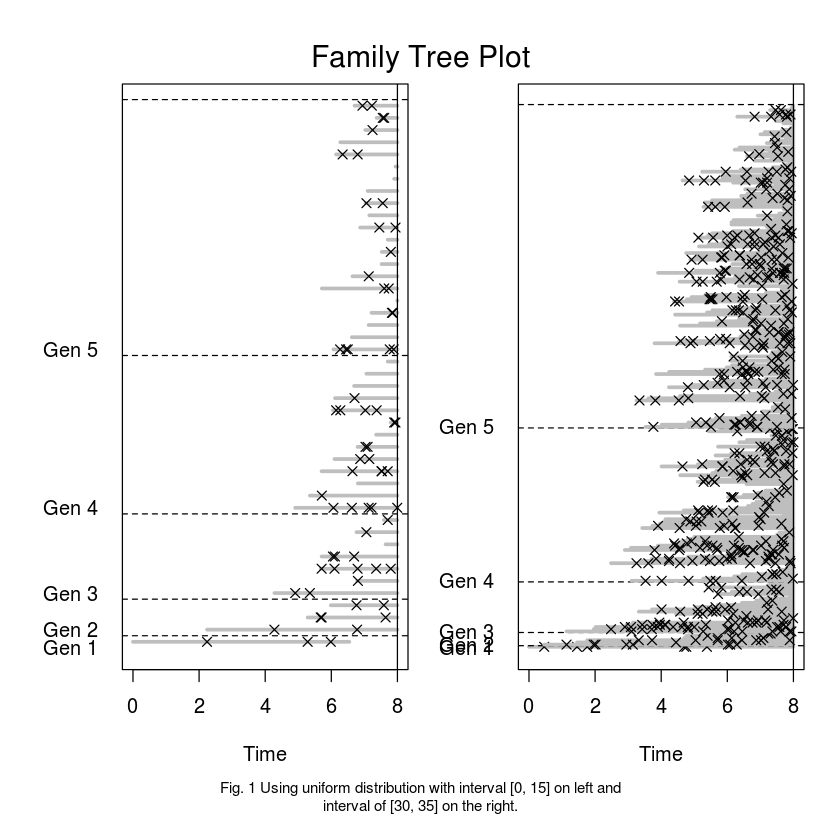

In [10]:
set.seed(seed2)
treeVT = familyTreeT2(lambda = 1, maxTime=8, FUN=runif, min=0, max=15)
treeVT2 = familyTreeT2(lambda = 1, maxTime=8, FUN=runif, min=30, max=35)

par(mfrow = c(1,2), oma = c(3,1,3,1))
makePlot(treeVT)
makePlot(treeVT2)
mtext("Family Tree Plot", side=3, outer=TRUE, cex=1.5)
mtext(paste("Fig. 1 Using uniform distribution with interval [0, 15] on left and\ninterval ",
            "of [30, 35] on the right.", sep=""), side=1, line=1, cex=0.75, outer=TRUE)

As Nolan and Lang did, we explore the simulation using the uniform distribution to provide lifetimes and trying different combination of the parameters `lambda` (used in deciding number of child processes), `min`, and `max`. Here we are setting the number of repeats we want to do in a single trial as well as the maximum generations, and maximum offspring for each repeat.  Figure 2 plots each of the 8 trials with the number of jobs spawned on the x-axis and the number of generations on the y-axis. It can be difficult to tell with the min-max range change over each plot but with $\lambda = 0.1$ we see two distinct clusters in the data and a more continuous, single cluster when $\lambda = 0.01$.

In [11]:
trialLambdas = c(0.1, 0.1, 0.1, 0.1, 0.01, 0.01, 0.01, 0.01)
mins = seq(10, 45, by=5)
maxs = 1.4*mins
trialParams = matrix(c(trialLambdas, mins, maxs), ncol = 3)
mcTrialOutput = MCBA2(params = trialParams, repeats = 100, 
                     mG = 20, mO = 100, FUN=runif)
# save(mcTrialOutput, file = "mcTrialOutput.rda")

param set is  1 
param set is  2 
param set is  3 
param set is  4 
param set is  5 
param set is  6 
param set is  7 
param set is  8 


In [12]:
#look at the max number of jobs made in each trial and max number of generations
print(paste("max gens =", max(unlist(lapply(1:8, function(i) max(mcTrialOutput[[i]][1]))))))
print(paste("max jobs =", max(unlist(lapply(1:8, function(i) max(mcTrialOutput[[i]][2]))))))

[1] "max gens = 14"
[1] "max jobs = 504"


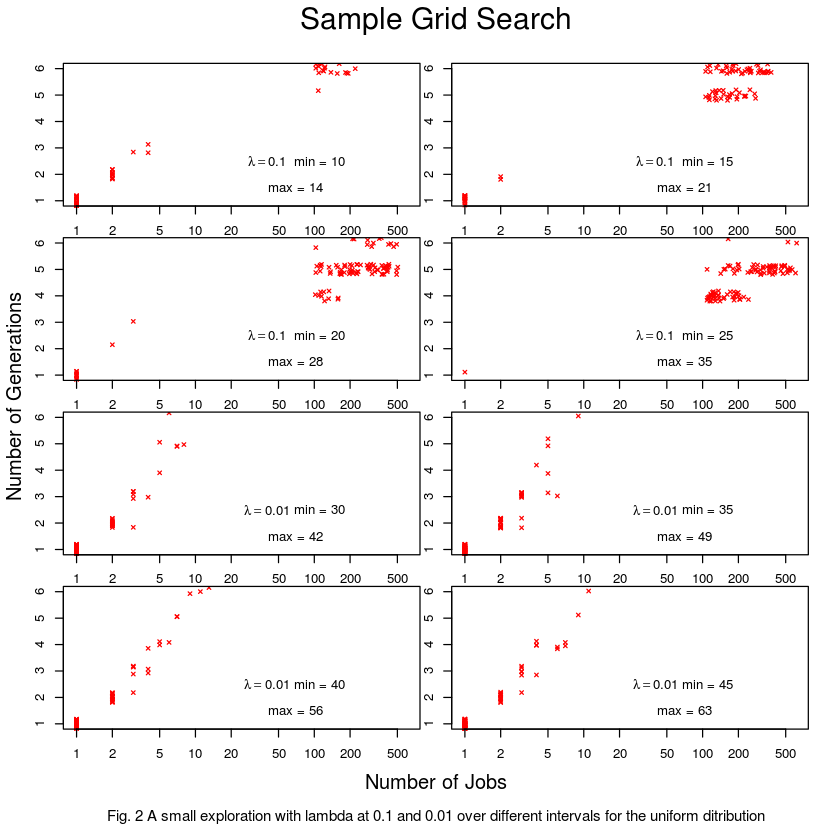

In [13]:
oldPar = par(mfrow = c(4, 2), mar=c(1,1,1,1), oma=c(6,3,3,1))

xshift = 0
invisible(mapply(function(oneSet, lambda, min, max) {
  plot(x = oneSet[2,], y = jitter(oneSet[1, ], 1), log = "x",
       ylim = c(1,6), xlim = c(1, 600), pch = 4, cex = 0.6, col=2, ann=FALSE)
  text(x = xshift + 40, y = 2.5, bquote(paste(lambda == .(lambda))) )
  text(x = xshift + 110, y = 2.5, paste("min =", min))
  text(x = xshift + 70, y = 1.5, paste("max =", max))
  }, 
  mcTrialOutput, lambda = trialLambdas, min = mins, max = maxs))

mtext("Sample Grid Search", side=3, line=1, outer=TRUE, cex=1.5)
mtext("Number of Generations", side=2, line=1.5, outer=TRUE, cex=1.0)
mtext("Number of Jobs", side=1, line=2, outer=TRUE, cex=1.0)
mtext(paste("Fig. 2 A small exploration with lambda at 0.1 and 0.01 over different intervals",
      "for the uniform ditribution"), side=1, line=4, outer=TRUE, cex=0.75)
par(oldPar)

A note about the code below: `expand.grid` makes a cartesian product of all variables passed to it so if we pass in the `maxs` variable we will yield min-max combinations that don't make sense (i.e. max < min). To avoid this we simply pass in `mins` and compute the column of maximums on the `paramGrid` variable itself.

In [14]:
lambdas = c(0.01, 0.03, 0.09, 0.3, 0.9, 3, 9)
mins = seq(1, length.out=15, by=3)
maxs = mins*1.4
paramGrid = as.matrix(expand.grid(lambdas, mins)) #don't put maxs in there
paramGrid = cbind(paramGrid, paramGrid[,2]*1.4) #make it afterwards

mcGrid = MCBA2(params = paramGrid, repeats = 100, mG = 20,
                mO = 100, FUN=runif)

param set is  1 
param set is  2 
param set is  3 
param set is  4 
param set is  5 
param set is  6 
param set is  7 
param set is  8 
param set is  9 
param set is  10 
param set is  11 
param set is  12 
param set is  13 
param set is  14 
param set is  15 
param set is  16 
param set is  17 
param set is  18 
param set is  19 
param set is  20 
param set is  21 
param set is  22 
param set is  23 
param set is  24 
param set is  25 
param set is  26 
param set is  27 
param set is  28 
param set is  29 
param set is  30 
param set is  31 
param set is  32 
param set is  33 
param set is  34 
param set is  35 
param set is  36 
param set is  37 
param set is  38 
param set is  39 
param set is  40 
param set is  41 
param set is  42 
param set is  43 
param set is  44 
param set is  45 
param set is  46 
param set is  47 
param set is  48 
param set is  49 
param set is  50 
param set is  51 
param set is  52 
param set is  53 
param set is  54 
param set is  55 
param set is  56 
p

In [15]:
logUQkids = sapply(mcGrid, function(x) 
               log(quantile(x[2, ], probs = 0.75), base = 10))

UQCut = cut(logUQkids, breaks = c(-0.1, 1, 3, max(logUQkids)) )
color3 = c("#b3cde3aa", "#8856a7aa", "#810f7caa")
colors = color3[UQCut]

Since we chose `maxs` to be equal to `1.4*mins` we can simply plot `mins` on the y-axis in the 3d scatter plot below. Figure 3 shows the scatter plot of the log of the upper quartile of the number of jobs generated in each trial. The number of offspring seem to decrease as lambda increases as evidinced by the height of the points and the number of points making it into the highest cutoff. As already expected, the number of offspring increases as the range minimum increases; this is written in the code for `GenKidsV`: `rpois(n = length(parentAge), lambda = lambda * parentAge)`.

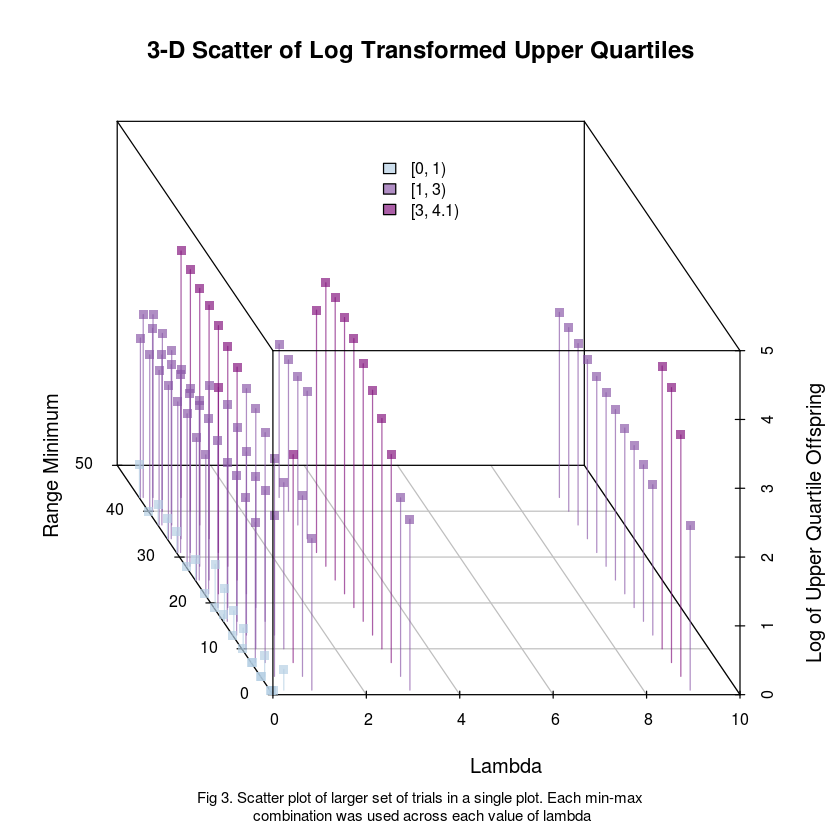

In [16]:
library(scatterplot3d)
sdp = scatterplot3d(x = paramGrid[ , 1], y = paramGrid[ , 2], 
                    z = logUQkids, pch = 15, color = colors,
                    xlab = "Lambda", ylab = "Range Minimum",
                    zlab = "Log of Upper Quartile Offspring",
                    angle = 120, type="h",
                   main="3-D Scatter of Log Transformed Upper Quartiles")
mtext(paste("Fig 3. Scatter plot of larger set of trials in a single plot. Each min-max\n",
           "combination was used across each value of lambda"), side=1, line=3.5, cex=0.75)
legend("top", inset = .08, bty = "n", cex = 0.8,
       legend = c("[0, 1)", "[1, 3)", "[3, 4.1)"), 
       fill = color3)

Figure 4 below shows the distribution of high volume trials over the parameters lambda and range minimum. A high volume trial is one that has either more than 20 generations or has more than 1000 jobs. These thresholds are an artifact of the authors' example but show an interesting distribution for our data; if following the same motivation and choosing the cutoffs used to create `mcGrid` (20 generations, 100 offspring) we get a less interesting view.

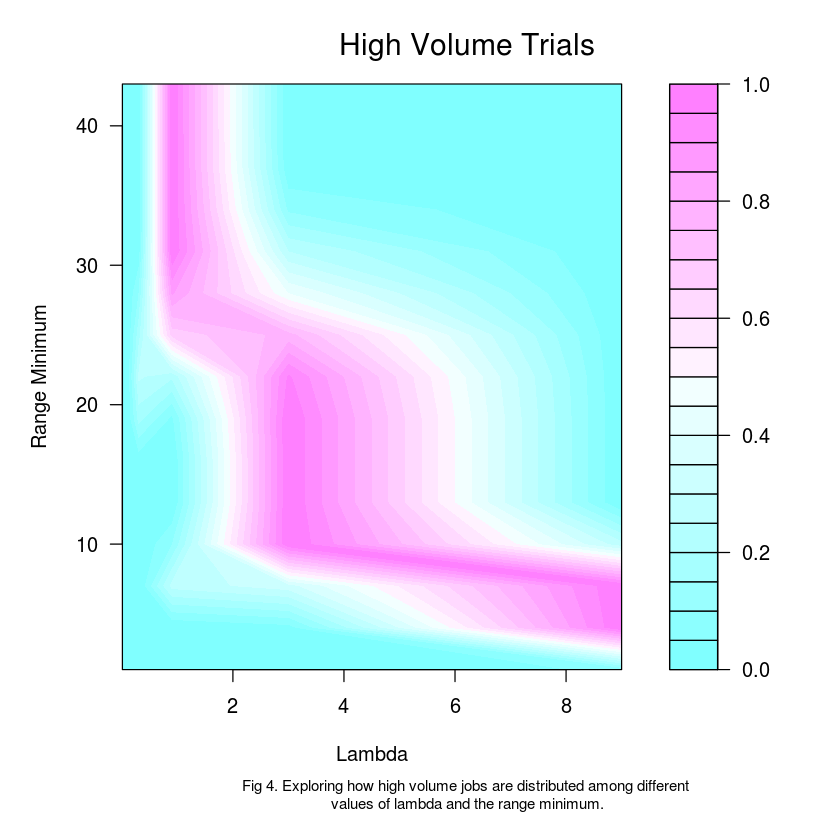

In [17]:
oldPar  = par(mar = c(4.1, 4.1, 0.5, 0.5), oma=c(3,1,3,1))

mcGridAlive = sapply(mcGrid, function(oneParamSet) {
  sum((oneParamSet[1,] == 20) | (oneParamSet[2,] > 1000)) / 
    length(oneParamSet[2,]) })

filled.contour(lambdas, mins, 
               matrix(mcGridAlive, nrow = length(lambdas), 
                      ncol = length(mins)), 
               xlab = "Lambda", ylab = "Range Minimum", 
               xlim = c(min(lambdas), max(lambdas)), ylim = c(min(mins), max(mins))) 
mtext("High Volume Trials", side=3, line=1, cex=1.5)
mtext(paste("Fig 4. Exploring how high volume jobs are distributed among different",
           "\nvalues of lambda and the range minimum."), side=1, line=5, cex=0.75)
par(oldPar)

Now we explore which jobs are better than the mean of the number of offspring over all trials. Figure 5 shows the result using a more discrete color scale (0.1 length bins). The shape is similar to the shape found in figure 4 which could indicate that the high volume trials above were driven mostly the number of jobs spawned rather than the number of generations. Aesthetically, it vaguely resembles a level in an 8-bit platformer game.

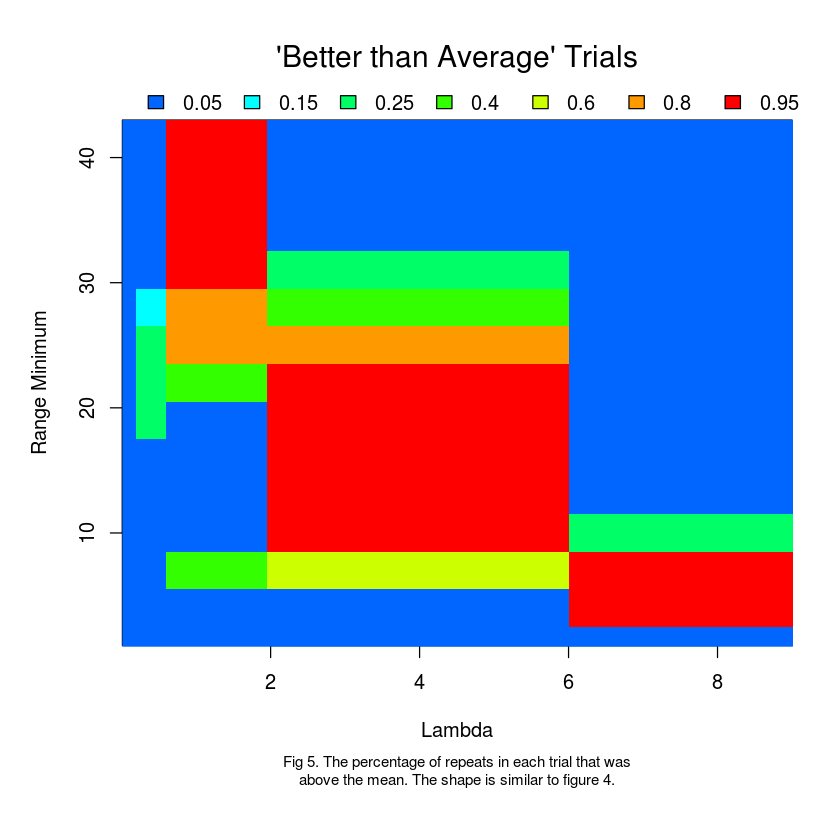

In [18]:
oldPar  = par(mar = c(4.1, 4.1, 2, 1), oma=c(4,1,3,1))

mn = mean(sapply(mcGrid, function(trial) trial[2,]))
#we're different, seeing how many had more than the overall mean
#because almost everyone had 20 or more child processes
mcGridProp20kids = sapply(mcGrid, function(oneParamSet) {
  sum(oneParamSet[2,] > mn) / length(oneParamSet[2,]) })

mcGridProp20kidsMat = matrix(mcGridProp20kids, 
                             nrow = length(lambdas), 
                             ncol = length(mins))

breaks = c(0, 0.10, 0.2, 0.3, 0.5, 0.7, 0.9, 1)
colors = rev(rainbow(10))[-(1:3)]

image(lambdas, mins, mcGridProp20kidsMat, col = colors,
      breaks = breaks, xlab = "Lambda", ylab = "Range Minimum", 
      xlim = c(min(lambdas), max(lambdas)), ylim = c(min(mins), max(mins)))

midBreaks = (breaks[ -8 ] + breaks[ -1 ]) / 2
legend(x = 0.1, y = 46.5, legend = midBreaks, fill = colors, 
       bty = "n", ncol = 7,  xpd = TRUE)

mtext("'Better than Average' Trials", side=3, line=2, cex=1.5)
mtext(paste("Fig 5. The percentage of repeats in each trial that was\nabove",
           "the mean. The shape is similar to figure 4."), side=1, line=5, cex=0.75)
    
par(oldPar)

## Results

The modification of the main functions used in this simulation were easily attained by using the extra arguments convention in `R` and can now be used to similarly explore the use of various probability distributions. The above shows a similar exploration as done by Nolan and Lang but using the uniform distribution. The views shown in figure 4 and 5 are somewhat puzzling as I expected that high volume and "better than average" jobs would dominate the top-right of the plots where both lambda and lifespan were larger (and thus a higher expected number of child jobs?).

## Conclusion

Simulation can be a powerful tool especially when any probability density function can be admitted. Coupled with bootstrapping and density estimation, nearly any process in the real world could be decently simulated.

## References
[1] Nolan, Deborah and Lang, Temple. Data Science in R: A Case Studies Approach, Chapter 7: Simulation Study of a Branching Process. 2015 Taylor & Francis Group, LLC.